In [2]:
from yfinance import Ticker, download
import pandas as pd
import numpy as np
from scipy.stats import kendalltau, spearmanr
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.fft import fft, fftfreq, ifft

In [3]:
avail_cryptos = pd.read_excel("yf-crypto-tickers.xlsx").set_index("Unnamed: 0")["Tickers"]
df_close = pd.DataFrame()

for i in range(len(avail_cryptos)):
    df = Ticker(avail_cryptos[i]).history(period="1y")["Close"].rename(avail_cryptos[i])
    df_close = pd.concat([df_close, df], axis=1)
    
df_close = df_close.dropna(axis=1)

# Example of a lagged rolling correlation between BTC and ETH

In [5]:
def lag_roll_corr(series1, series2, lag):
    """
    Inputs:
    - series1: series 1 who's current day values have their rolling correlation taken with series2's future lagged values - the hypothethical independent variable
    - series2: the series which has it's future values correlated with series1's past values - the hypothetical dependent variable
    Outputs:
    - lagged rolling correlation with series 1 current day values correlated with series 2 future lagged values
    """
    pair = pd.concat([series1, series2], axis=1)
    pair.iloc[:, 1] = pair.iloc[:, 1].shift(-lag)
    lagged_rcorr = pair.iloc[:, 0].rolling(lag).corr(pair.iloc[:, 1])
    lagged_rcorr = lagged_rcorr.dropna()
    return lagged_rcorr

def lag_roll_kendall(series1, series2, lag):
    """
    Inputs:
    - series1: series 1 who's current day values have their rolling kendall tau taken with series2's future lagged values - the hypothethical independent variable
    - series2: the series which has it's future values correlated with series1's past values - the hypothetical dependent variable
    Outputs:
    - lagged rolling correlation with series 1 current day values rank correlated (kendall tau) with series 2 future lagged values
    """
    ken_values = []
    series2 = series2.shift(-lag).dropna()
    
    for i in range(0, len(series2)-lag+1):
        ken_values.append(kendalltau(series1[0+i:lag+i], series2[0+i:lag+i])[0])

    return pd.DataFrame(ken_values).set_index(series1.index[lag-1:len(btc)-lag])

def lag_roll_spearman(series1, series2, lag):
    """
    Inputs:
    - series1: series 1 who's current day values have their rolling kendall tau taken with series2's future lagged values - the hypothethical independent variable
    - series2: the series which has it's future values correlated with series1's past values - the hypothetical dependent variable
    Outputs:
    - lagged rolling correlation with series 1 current day values rank correlated (spearman r) with series 2 future lagged values
    """
    ken_values = []
    series2 = series2.shift(-lag).dropna()
    
    for i in range(0, len(series2)-lag+1):
        ken_values.append(spearmanr(series1[0+i:lag+i], series2[0+i:lag+i])[0])

    return pd.DataFrame(ken_values).set_index(series1.index[lag-1:len(btc)-lag])


# example of how to run the functions
lag = 14
btc = df_close.iloc[:, 0]
eth = df_close.iloc[:, 1]
lag_rollktau = lag_roll_kendall(btc, eth, lag)
lag_roll_spearr = lag_roll_spearman(btc, eth, lag)
lag_roll_pears = lag_roll_corr(btc, eth, lag)

In [6]:
dependent_var = df_close.iloc[:, 2]

dependent_var.name

'DOGE-USD'

CKB-USD


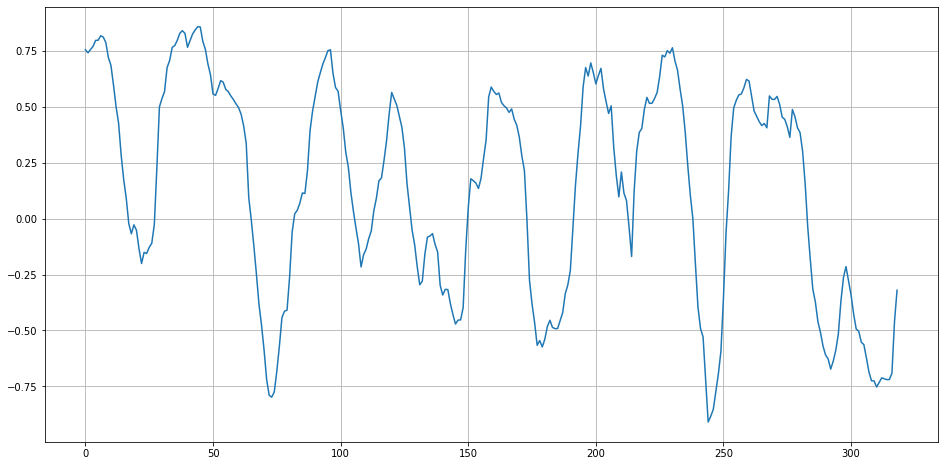

In [140]:
lag = 24
btc = df_close.iloc[:, 0]
dependent_var = df_close.iloc[:, 50]

print(dependent_var.name)

lag_roll_pears = lag_roll_corr(btc, dependent_var, lag)

plt.figure(figsize=(16,8))
plt.plot(np.arange(0, len(lag_roll_pears), 1), lag_roll_pears) # plotting lagged rolling pearson correlation
plt.grid()
plt.show()

# Fitting a sinewave to the data

In [141]:
import numpy, scipy.optimize
import pylab as plt
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess, maxfev=5000)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

tt = np.arange(0, len(lag_roll_pears), 1)
res = fit_sin(tt, lag_roll_pears)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

Amplitude=0.39737003322496783, Angular freq.=0.11169208374161585, phase=2.564229052007316, offset=0.15165645976293998, Max. Cov.=0.023175376596066628


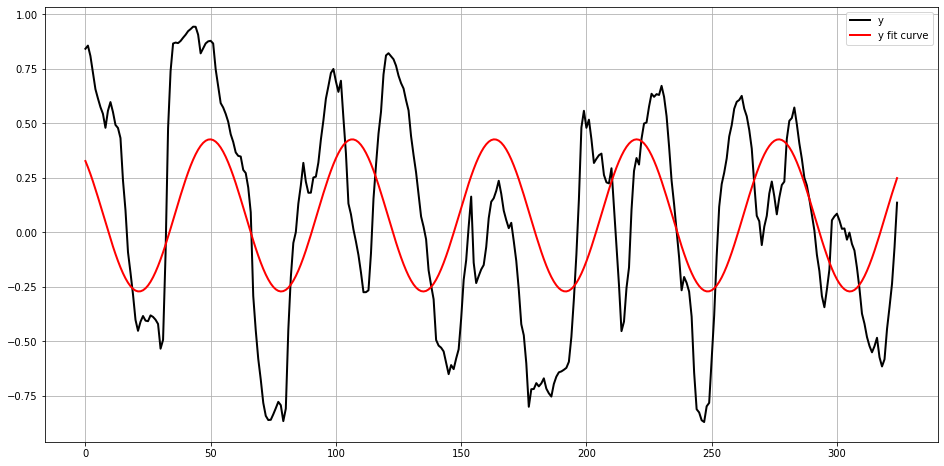

In [74]:
plt.figure(figsize=(16,8))
plt.plot(tt, lag_roll_pears, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

## Error Functions between Sine and Original

In [75]:
# MSE
mse = sum((lag_roll_pears.values - res["fitfunc"](tt))**2)

# MAE
mae = sum(abs(lag_roll_pears.values - res["fitfunc"](tt)))


## Putting it all together and finding the lags that correspond closest to a period sine wave

In [194]:
btc = df_close.iloc[:, 0]
dependent_var = df_close.iloc[:, 2]

output = []

for lag in range(2, 45):
    
    #print(lag)

    # obtaining the correlations
    lag_roll_pears = lag_roll_corr(btc, dependent_var, lag)

    # generating the sinewave
    tt = np.arange(0, len(lag_roll_pears), 1)
    res = fit_sin(tt, lag_roll_pears)

    # error functions
    mse = sum((lag_roll_pears.values - res["fitfunc"](tt))**2)
    mae = sum(abs(lag_roll_pears.values - res["fitfunc"](tt)))
    period = int((2*np.pi)/res["omega"])
    output.append([lag, mse, mae, period, btc.name, dependent_var.name])
    
display(output)

[[2, 350.26526752368187, 350.26526928781567, 5, 'BTC-USD', 'DOGE-USD'],
 [3, 176.94751921361674, 227.37922303822558, 5, 'BTC-USD', 'DOGE-USD'],
 [4, 141.1162274872322, 197.470104438816, 20, 'BTC-USD', 'DOGE-USD'],
 [5, 106.0308037618321, 165.4669569830184, 17, 'BTC-USD', 'DOGE-USD'],
 [6, 94.43418372645029, 158.26373386673046, 39, 'BTC-USD', 'DOGE-USD'],
 [7, 90.34242134189822, 151.62802928474818, 38, 'BTC-USD', 'DOGE-USD'],
 [8, 88.92077515284906, 151.6869002741028, 68, 'BTC-USD', 'DOGE-USD'],
 [9, 72.8469318387477, 137.16908259251798, 70, 'BTC-USD', 'DOGE-USD'],
 [10, 69.73258661773578, 134.4452995768234, 37, 'BTC-USD', 'DOGE-USD'],
 [11, 71.46318583694185, 134.60052595058454, 37, 'BTC-USD', 'DOGE-USD'],
 [12, 67.72816560256996, 127.67171775181559, 301, 'BTC-USD', 'DOGE-USD'],
 [13, 68.89171178278022, 128.41706140571566, 292, 'BTC-USD', 'DOGE-USD'],
 [14, 73.69569787193939, 134.672848128804, 37, 'BTC-USD', 'DOGE-USD'],
 [15, 63.25763852827601, 123.1395035419252, 37, 'BTC-USD', 'DOGE-

### Getting IDX of minimum MSEs or MAEs

In [204]:
mses = pd.DataFrame(output)[1].values
maes = pd.DataFrame(output)[2].values
k = 3

top_lags = pd.DataFrame(output)
columns = ["Lags", "MSE", "MAE", "Periodicity", "Independent Var", "Dependent Var"]
top_lags.columns = columns


top_lags = top_lags[top_lags["Periodicity"] < 100] # periodicity filter

idx = np.argpartition(top_lags["MSE"].values, k) # getting best fits 

top_lags = top_lags.loc[idx[:k]] # keeping top 'k' optimal fits

top_lags

,Lags,MSE,MAE,Periodicity,Independent Var,Dependent Var
17,19,62.787604,122.827761,55,BTC-USD,DOGE-USD
18,20,55.159690,112.483782,33,BTC-USD,DOGE-USD
19,21,46.149583,103.592875,33,BTC-USD,DOGE-USD


### Plotting the optimal periodic lags

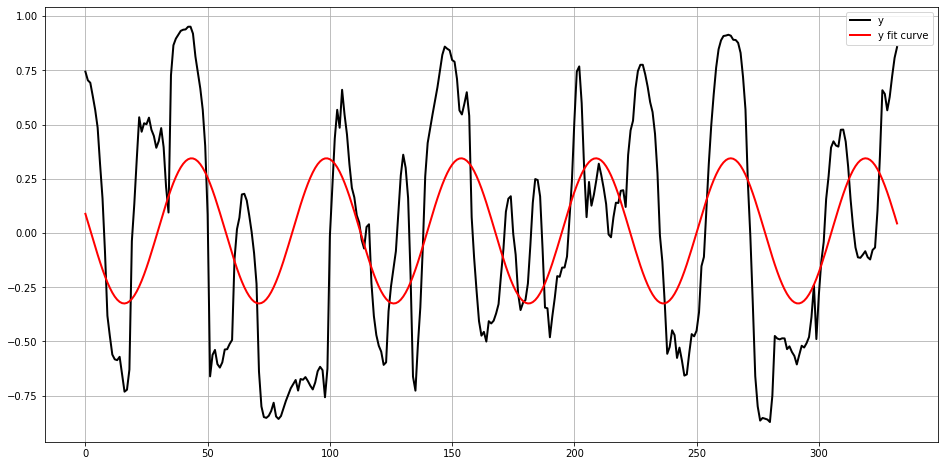

In [203]:
# check the lag plot
lag = idx[0]
btc = df_close.iloc[:, 0]
dependent_var = df_close.iloc[:, 2]

lag_roll_pears = lag_roll_corr(btc, dependent_var, lag)

# generating the sinewave
tt = np.arange(0, len(lag_roll_pears), 1)
res = fit_sin(tt, lag_roll_pears)

plt.figure(figsize=(16,8))
plt.plot(tt, lag_roll_pears, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

### Periodicity of Sine

In [149]:
period = (2*np.pi)/res["omega"]

print("Periodicity of Sine is: ", int(np.round(period)), " Days.")

Periodicity of Sine is:  56  Days.


# Fitting 2 Sinewaves to data?

In [21]:
import numpy, scipy.optimize
import pylab as plt
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])
    guess = np.append(guess, guess)

    def doublesinfunc(t, A, w, p, c, A2, w2, p2, c2):  return (A * numpy.sin(w*t + p) + c) + (A2 * numpy.sin(w2*t + p2) + c2)
    popt, pcov = scipy.optimize.curve_fit(doublesinfunc, tt, yy, p0=guess)
    A, w, p, c, A2, w2, p2, c2 = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: (A * numpy.sin(w*t + p) + c) + (A2 * numpy.sin(w2*t + p2) + c2)
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

tt = np.arange(0, len(lag_roll_pears), 1)
yy = lag_roll_pears
res = fit_sin(tt, yy)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

Amplitude=0.2493381269269311, Angular freq.=0.14896957507734185, phase=6.739315075053622, offset=-4.590125508090971, Max. Cov.=1705269590251.6182


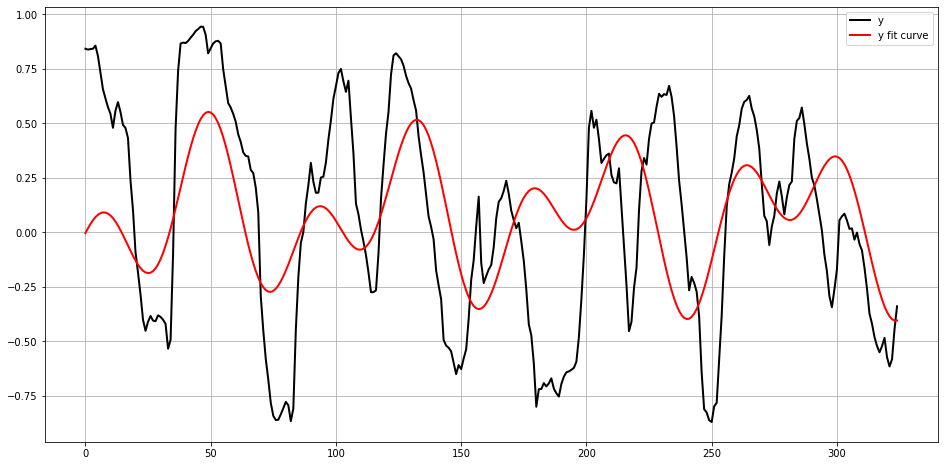

In [22]:
plt.figure(figsize=(16,8))
plt.plot(tt, yy, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

## Attempting to Analyse Power Spectral Density of Lagged Correlations (looking for harmonic frequencies - recurring correlation patterns)

- Plot Autocorrelation
- Plot normalised power spectral density

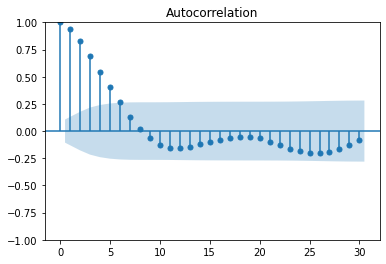

In [159]:
autocorr = []

for i in range(1, 160):
    shifted = lag_roll_pears.shift(i).dropna()
    autocorr.append(np.corrcoef(shifted, lag_roll_pears[-len(shifted):])[0][1])
    
plot_acf(lag_roll_pears, lags=30)
plt.show()

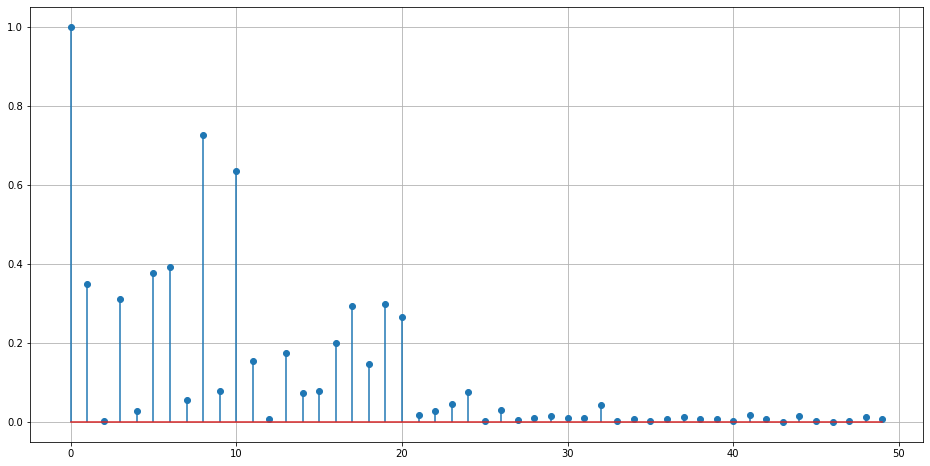

In [158]:
f = fft((np.array(lag_roll_pears)))
frq = f*np.conj(f)
norm_frq = np.abs(frq)/np.max(np.abs(frq))

plt.figure(figsize=(16, 8))
plt.stem(norm_frq[:50])
plt.grid()

In [144]:
ACF = acf(lag_roll_pears) # ACF
PSD = fft(ACF) # PSD

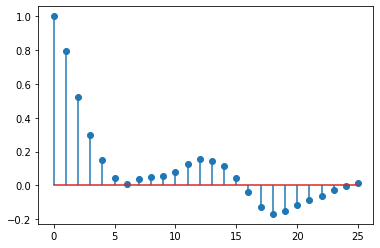

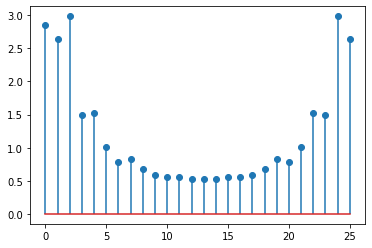

In [145]:
plt.stem(ACF)
plt.show()
plt.stem(np.abs(PSD))
plt.show()

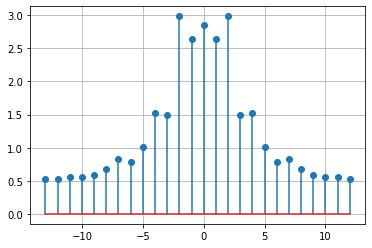

In [146]:
q = np.abs(PSD[0:13])
p = np.abs(PSD[13:])
x = np.arange(-len(PSD)/2 , len(PSD)/2  , 1)
plt.stem(x, np.append(p, q))
plt.grid()